In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from tqdm import tqdm

from sklearn.metrics import f1_score, log_loss, confusion_matrix,classification_report
import scikitplot as skplt
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [5]:
data_train = pd.read_csv("aps_failure_training_set.csv")
data_test = pd.read_csv("aps_failure_test_set.csv")

In [6]:
data_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [16]:
data_train.isnull().sum().sort_values(ascending=True)

class     0
cn_009    0
co_000    0
cp_000    0
cq_000    0
         ..
ba_006    0
ba_007    0
ba_008    0
ba_000    0
eg_000    0
Length: 171, dtype: int64

In [14]:
data_train.isna().sum().sort_values(ascending=True)

class     0
cn_009    0
co_000    0
cp_000    0
cq_000    0
         ..
ba_006    0
ba_007    0
ba_008    0
ba_000    0
eg_000    0
Length: 171, dtype: int64

In [17]:
data_train.replace('na','-1',inplace=True)
data_test.replace('na','-1',inplace=True)

In [18]:
data_train['class'] = pd.Categorical(data_train['class']).codes
data_test['class'] = pd.Categorical(data_test['class']).codes

In [19]:
print(['neg', 'pos'])
print(np.bincount(data_train['class'].values))
print(np.bincount(data_test['class'].values))

['neg', 'pos']
[59000  1000]
[15625   375]


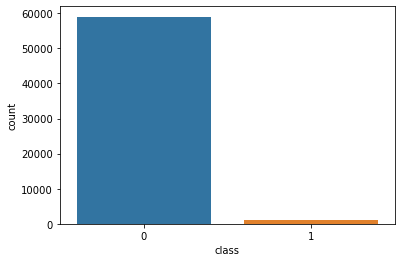

In [20]:
import seaborn as sns
sns.countplot(x='class',data=data_train)

In [21]:
y_train = data_train['class'].copy(deep=True)
X_train = data_train.copy(deep=True)
X_train.drop(['class'], inplace=True, axis=1)

y_test = data_test['class'].copy(deep=True)
X_test = data_test.copy(deep=True)
X_test.drop(['class'], inplace=True, axis=1)

# strings to float
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

In [22]:
cat_features = list(range(0, X_train.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169]


In [23]:
print(X_train.dtypes)
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]

aa_000    float64
ab_000    float64
ac_000    float64
ad_000    float64
ae_000    float64
           ...   
ee_007    float64
ee_008    float64
ee_009    float64
ef_000    float64
eg_000    float64
Length: 170, dtype: object


In [24]:
def evaluate(y_test,y_pred,y_pred_proba):
    if len(y_pred)>0:
        f1 = f1_score(y_test,y_pred,average="weighted")
        print("F1 score: ",f1)
    if len(y_pred_proba)>0:
        logloss = log_loss(y_test,y_pred_proba, eps=1e-15, normalize=True, sample_weight=None, labels=None)
        print("Log loss for predicted probabilities:",logloss)

In [25]:
forest_clf = RandomForestClassifier(n_estimators=250,n_jobs=-1)
forest_clf.fit(X_train,y_train)
y_pred_rf = forest_clf.predict(X_test)
y_pred_proba_rf = forest_clf.predict_proba(X_test)
evaluate(y_test,y_pred_rf,y_pred_proba_rf)

F1 score:  0.9920972586144634
Log loss for predicted probabilities: 0.023214592763793597


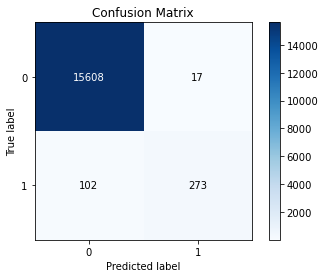

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15625
           1       0.94      0.73      0.82       375

    accuracy                           0.99     16000
   macro avg       0.97      0.86      0.91     16000
weighted avg       0.99      0.99      0.99     16000



In [29]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf ).ravel()
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rf, normalize=False)
plt.show()
print(classification_report(y_test,y_pred_rf))

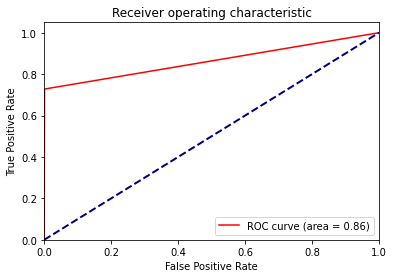

In [30]:
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [31]:
y_test_predictions_rec = y_pred_proba_rf[:,1] > 0.1
y_test_predictions_prec = y_pred_proba_rf[:,1] > 0.85

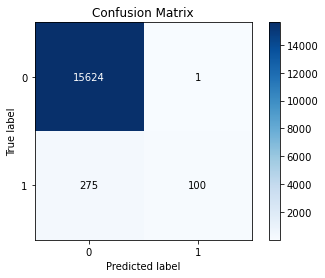

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15625
           1       0.99      0.27      0.42       375

    accuracy                           0.98     16000
   macro avg       0.99      0.63      0.71     16000
weighted avg       0.98      0.98      0.98     16000



In [32]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_predictions_prec, normalize=False)
plt.show()
print(classification_report(y_test, y_test_predictions_prec))

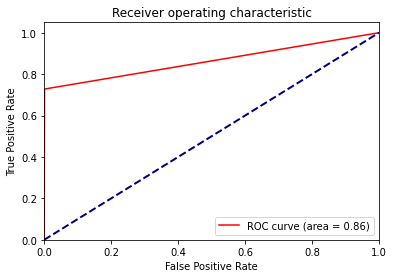

In [33]:
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [34]:
scores = forest_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

In [35]:
min_cost = np.inf
best_threshold = 0.5
costs = []
for threshold in tqdm(thresholds):
    y_pred_threshold = scores > threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    cost = 10*fp + 500*fn
    costs.append(cost)
    if cost < min_cost:
        min_cost = cost
        best_threshold = threshold
print("Best threshold: {:.4f}".format(best_threshold))
print("Min cost: {:.2f}".format(min_cost))

100%|██████████| 202/202 [00:08<00:00, 23.73it/s]

Best threshold: 0.0320
Min cost: 8570.00


8570

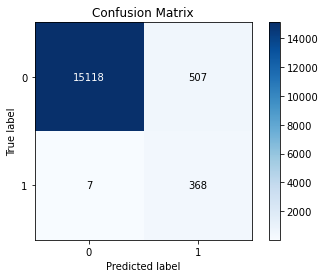

In [36]:
y_pred_test_rf = forest_clf.predict_proba(X_test)[:,1] > best_threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test_rf).ravel()
skplt.metrics.plot_confusion_matrix(y_test,y_pred_test_rf, normalize=False)
10*fp + 500*fn

### Total failure cost prediction with improved threshold (0.0440) is 8390 using Random Forest.

In [37]:
bayes_clf = GaussianNB()
bayes_clf.fit(X_train,y_train)

GaussianNB()

In [38]:
y_pred__bayes = bayes_clf.predict(X_test)
y_pred_proba_bayes = bayes_clf.predict_proba(X_test)

In [39]:
evaluate(y_test,y_pred__bayes,y_pred_proba_bayes)

F1 score:  0.9736555655534687
Log loss for predicted probabilities: 1.0495551640880207


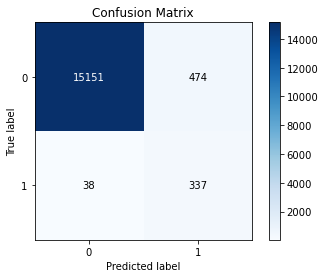

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     15625
           1       0.42      0.90      0.57       375

    accuracy                           0.97     16000
   macro avg       0.71      0.93      0.78     16000
weighted avg       0.98      0.97      0.97     16000



In [40]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred__bayes).ravel()
skplt.metrics.plot_confusion_matrix(y_test,y_pred__bayes, normalize=False)
plt.show()
print(classification_report(y_test,y_pred__bayes))

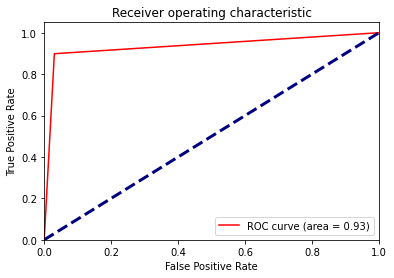

In [41]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_pred__bayes)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [42]:
xgb_clf = XGBClassifier(max_depth=5)
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)

In [44]:
evaluate(y_test,y_pred_xgb,y_pred_proba_xgb)

F1 score:  0.9929770450003862
Log loss for predicted probabilities: 0.021628509196962374


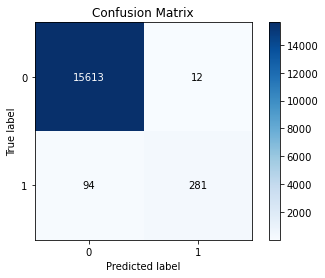

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15625
           1       0.96      0.75      0.84       375

    accuracy                           0.99     16000
   macro avg       0.98      0.87      0.92     16000
weighted avg       0.99      0.99      0.99     16000



In [45]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_xgb).ravel()
skplt.metrics.plot_confusion_matrix(y_test,y_pred_xgb, normalize=False)
plt.show()
print(classification_report(y_test,y_pred_xgb))

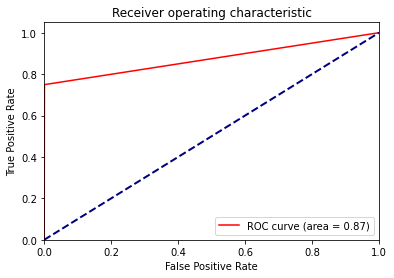

In [46]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_pred_xgb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [47]:
y_test_predictions_rec = y_pred_proba_xgb[:,1] > 0.1
y_test_predictions_prec = y_pred_proba_xgb[:,1] > 0.85

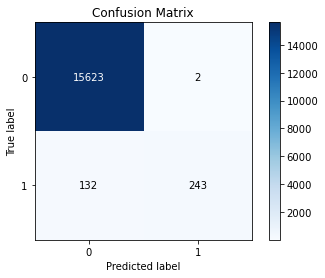

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15625
           1       0.99      0.65      0.78       375

    accuracy                           0.99     16000
   macro avg       0.99      0.82      0.89     16000
weighted avg       0.99      0.99      0.99     16000



In [48]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_predictions_prec, normalize=False)
plt.show()
print(classification_report(y_test, y_test_predictions_prec))

In [49]:
scores = xgb_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

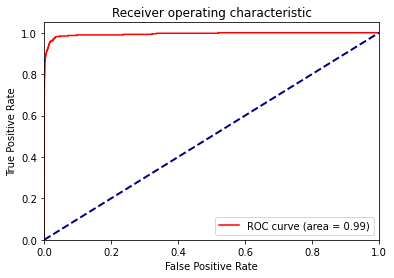

In [50]:
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [51]:
min_cost = np.inf
best_threshold = 0.5
costs = []
for threshold in tqdm(thresholds):
    y_pred_threshold = scores > threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    cost = 10*fp + 500*fn
    costs.append(cost)
    if cost < min_cost:
        min_cost = cost
        best_threshold = threshold
print("Best threshold: {:.4f}".format(best_threshold))
print("Min cost: {:.2f}".format(min_cost))

100%|██████████| 1362/1362 [00:53<00:00, 25.49it/s]

Best threshold: 0.0025
Min cost: 8900.00


8900

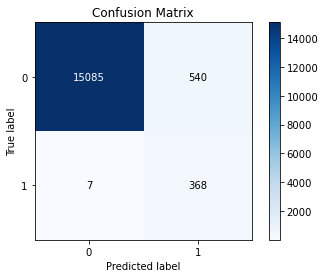

In [52]:
y_pred_test_xgb = xgb_clf.predict_proba(X_test)[:,1] > best_threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test_xgb).ravel()
skplt.metrics.plot_confusion_matrix(y_test,y_pred_test_xgb, normalize=False)
10*fp + 500*fn